In [1]:
# !pip install xgboost

In [2]:
import pickle
import pandas as pd
import numpy as np
import random, math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

from keras import Model, Sequential
from keras.layers import Dense, Dropout
from keras.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

import joblib
import xgboost as xgb
print("XGB Version:", xgb.__version__)

XGB Version: 2.0.0


In [3]:
# carregar os dados de entrada
inputs_file = 'input_db_29_08_2023_14_26_20.pkl'
with open(inputs_file, 'rb') as handle_inputs:
    inputs = pickle.load(handle_inputs)

In [4]:
inputs.head()

,site_lat,site_long,sat_long,freq,eirp,hsat,bw_total,bw_util,rolloff,mod,fec,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint
0,-16.284610,-53.833962,-16.791579,15.777944,55.604089,35786,36,16.155547,0.2,32APSK,126/180,12.731030,1.053027,0.721533,60.752933,25.492447,5.587639,0.517839
1,-19.589594,-47.124346,-25.670642,8.138563,68.860880,35786,36,22.226415,0.2,32APSK,135/180,13.567632,4.362265,0.351699,58.632002,13.328408,5.246875,1.412518
2,-19.167619,-34.986496,-2.622435,5.349325,56.252903,35786,36,35.827805,0.2,64APSK,162/180,19.590329,1.207189,0.530488,57.036432,28.600282,5.894995,1.506105
3,-7.438339,-65.779685,-40.611067,13.980570,79.680713,35786,36,14.203504,0.2,8PSK,100/180,5.407456,1.065575,0.366528,62.943757,30.125849,4.965485,1.081404
4,-31.421909,-51.281737,-86.449047,15.837202,66.010417,35786,36,9.488156,0.2,32APSK,126/180,12.731030,2.561817,0.116897,56.777167,21.047025,4.254455,0.368052


In [5]:
inputs = inputs.drop(columns=["hsat", "bw_total", "mod", "fec", "rolloff"])

In [6]:
# carregar os dados de saída - 
# apenas a coluna availability é relevante para o problema, 
# pode-se ignorar as demais para o treinamento e teste
results_file = 'results_db_29_08_2023_14_26_20.pkl'
with open(results_file, 'rb') as handle_results:
    results = pickle.load(handle_results)

In [7]:
results.head()

,availability,a_fs,a_g,a_c,a_r,a_s,a_t,a_tot,a_depoint,c_n0,...,earth_radius,elevation_angle,distance,fig_merit,noise_ground,noise_sky,ant_noise,noise_total,ant_gain,ant_3db
0,99.904,207.841452,0.322924,0.966845,9.079432,0.526741,10.383000,220.241483,2.017030,84.759447,...,6367.489544,43.741256,37499.215397,24.276649,10.0,10.860506,260.815713,286.308799,43.398944,1.263074
1,99.999,201.903879,0.065287,0.201974,7.102761,0.439884,7.383255,277.812514,68.525380,112.688241,...,6367.489544,56.474767,36698.322584,95.134206,10.0,3.208548,235.351027,248.680367,46.873483,0.591097
2,96.460,198.393586,0.065097,0.039061,0.016178,0.116006,0.193583,201.164695,2.577525,-99916.332614,...,6367.489544,47.007765,37271.796260,-100000.000000,10.0,3.867110,25.687222,54.289160,33.854824,3.249709
3,99.999,206.567603,0.201870,0.712902,27.381892,0.930295,28.312062,241.951596,7.071931,86.145051,...,6367.489544,59.412644,36547.299501,23.855004,10.0,5.183472,284.602019,314.728183,39.509835,1.408672
4,99.990,207.986262,0.381950,1.032110,16.817812,0.716087,18.246230,232.308445,6.075953,82.544269,...,6367.489544,37.330831,37986.968867,26.033504,10.0,12.583786,281.070225,302.118263,43.249134,0.517240


In [8]:
# preprocessamento da base de dados - 
# as linhas cuja coluna fig_merit têm valor igual a -100000 
# são casos inválidos e devem ser removidos 
filter_matrix = results.fig_merit != -100000
print(filter_matrix.head())
print(np.sum(filter_matrix))

0     True
1     True
2    False
3     True
4     True
Name: fig_merit, dtype: bool
1457619


In [9]:
filtered_inputs = inputs[filter_matrix]
filtered_results = results[filter_matrix]

           site_lat     site_long      sat_long          freq          eirp  \
count  1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06   
mean  -1.505471e+01 -5.330440e+01 -5.230916e+01  1.132981e+01  5.091215e+01   
std    1.061157e+01  1.080609e+01  3.258509e+01  4.041949e+00  1.763086e+01   
min   -3.368997e+01 -7.288998e+01 -1.079999e+02  3.000049e+00  1.500033e+01   
25%   -2.430390e+01 -6.240066e+01 -8.093161e+01  7.965716e+00  3.691857e+01   
50%   -1.470179e+01 -5.317498e+01 -5.223987e+01  1.150008e+01  5.183633e+01   
75%   -5.817384e+00 -4.398199e+01 -2.366515e+01  1.483480e+01  6.597661e+01   
max    2.819986e+00 -3.480004e+01  2.999920e+00  1.799999e+01  7.999994e+01   

            bw_util  snr_threshold      ant_size       ant_eff      lnb_gain  \
count  1.457619e+06   1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06   
mean   1.850569e+01   8.798743e+00  2.383836e+00  5.565397e-01  5.999881e+01   
std    1.009771e+01   5.843946e+00  1.251949e+00

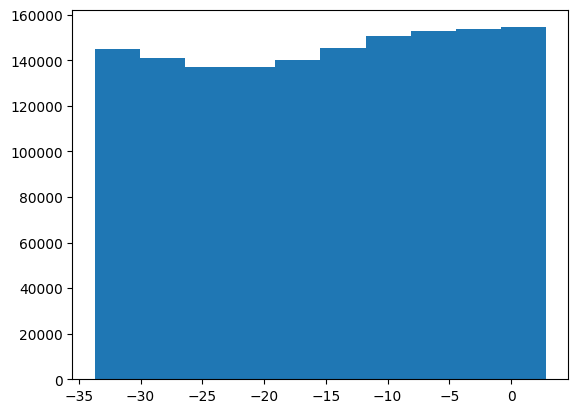

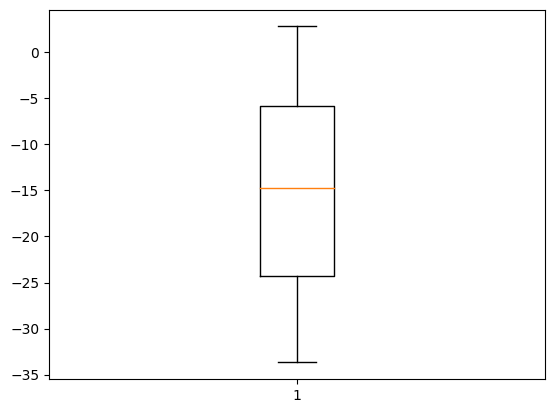

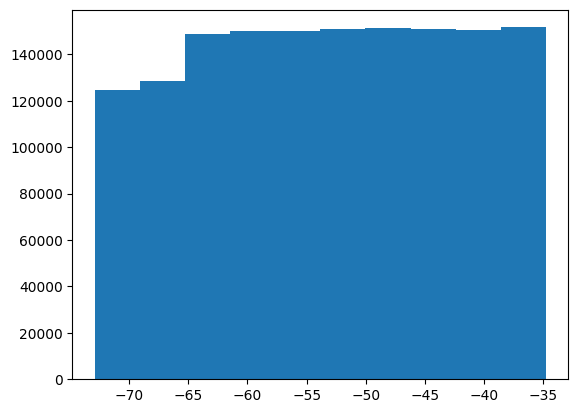

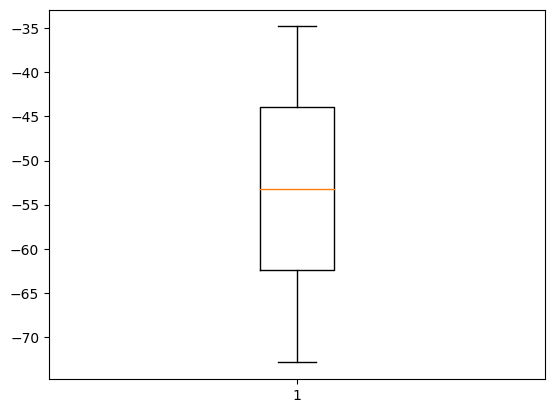

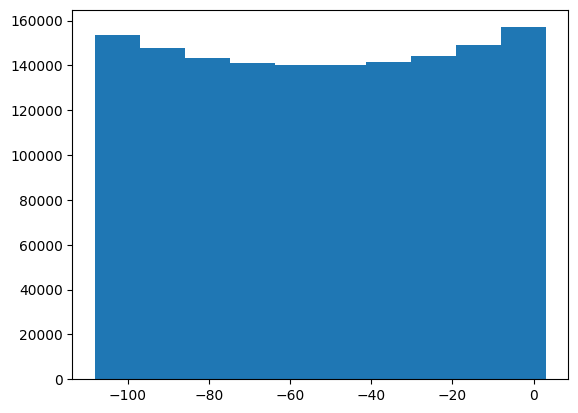

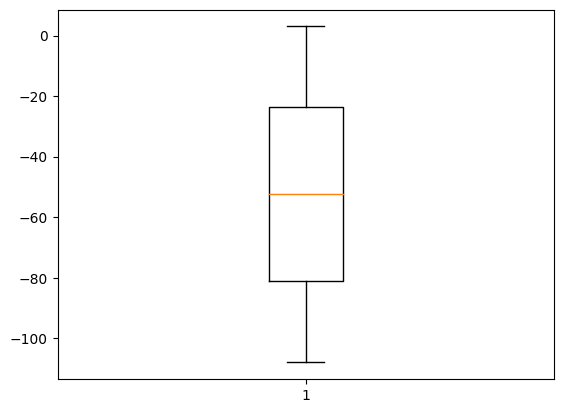

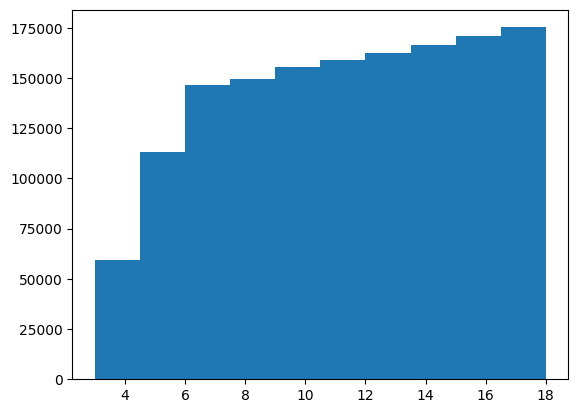

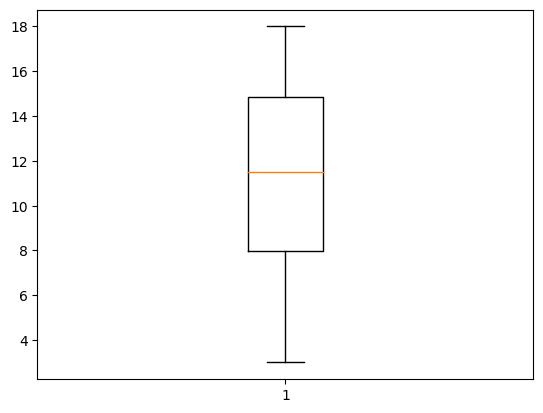

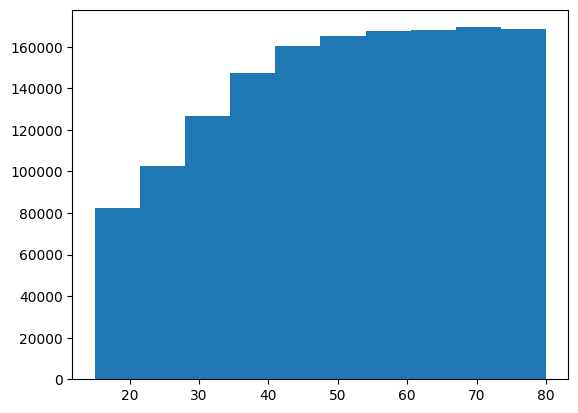

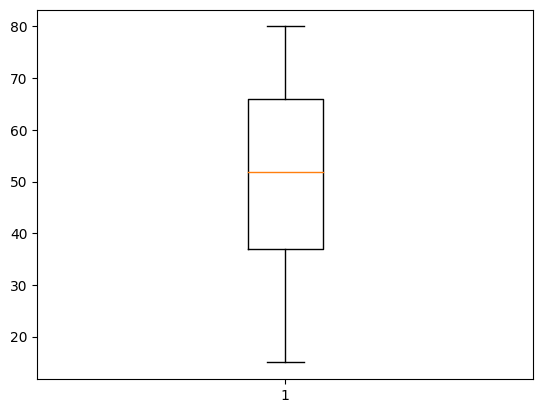

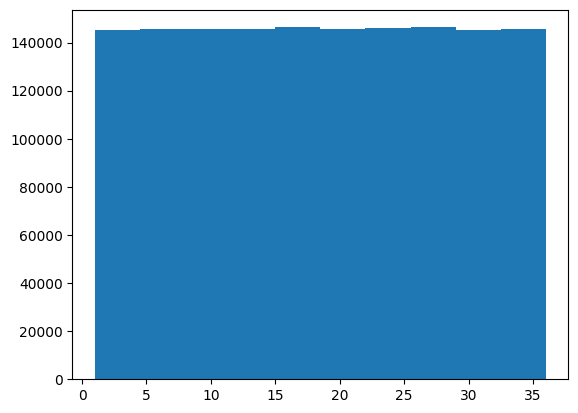

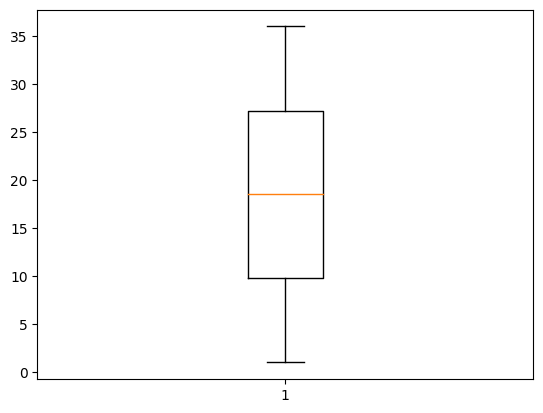

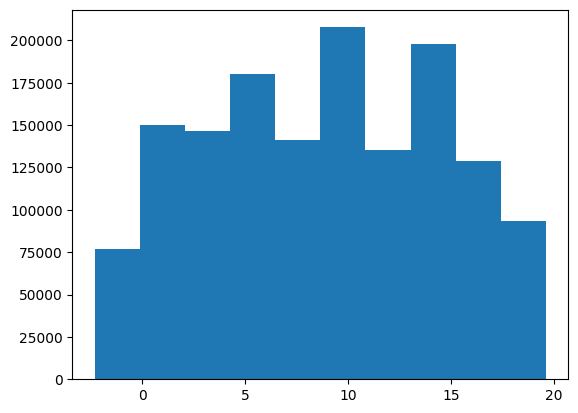

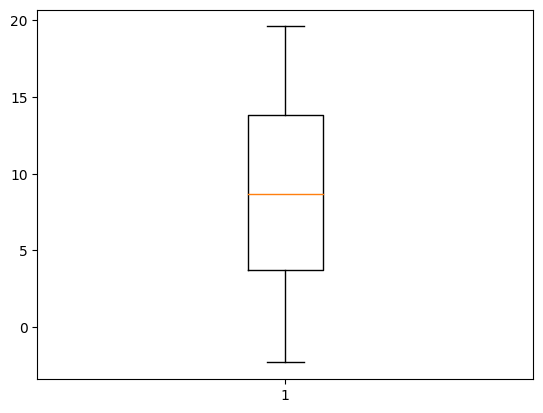

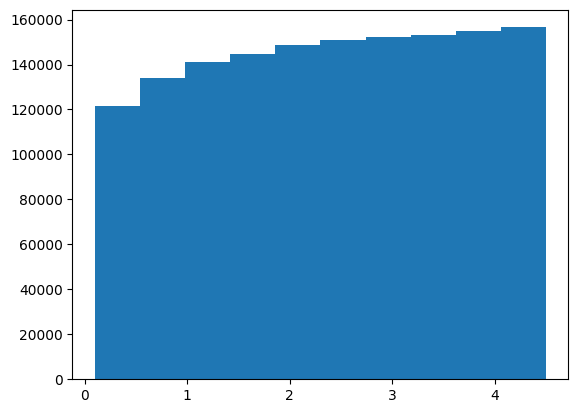

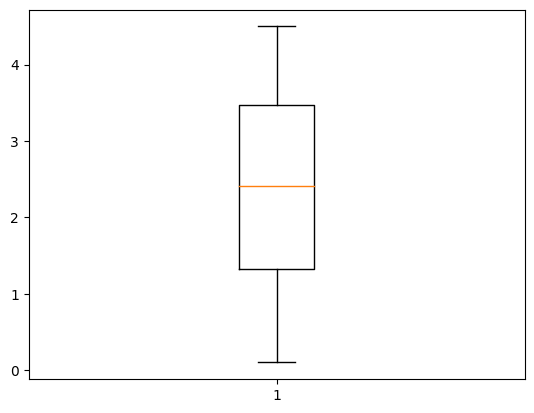

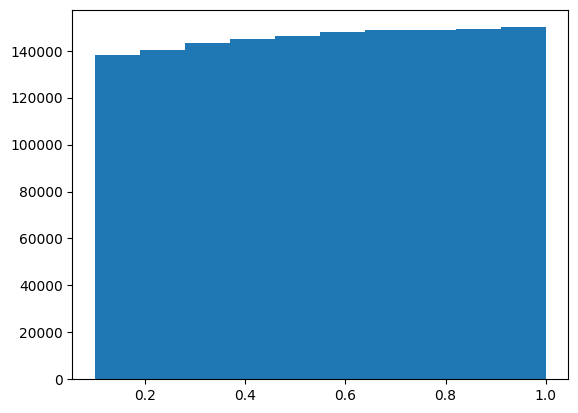

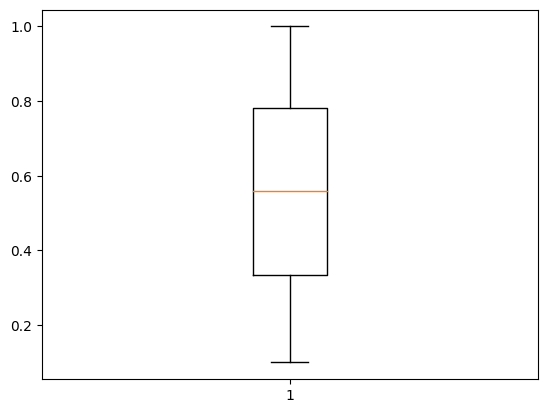

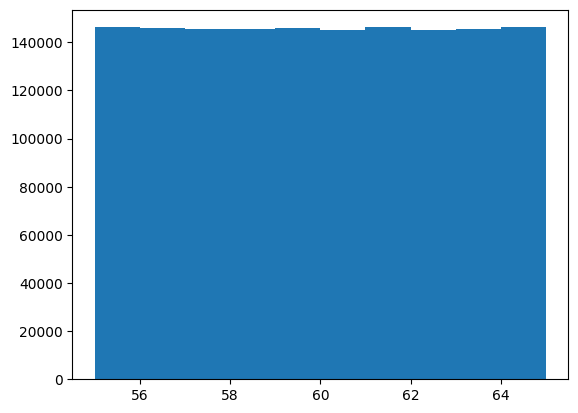

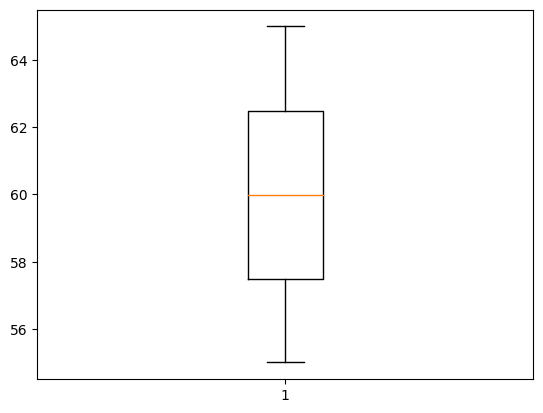

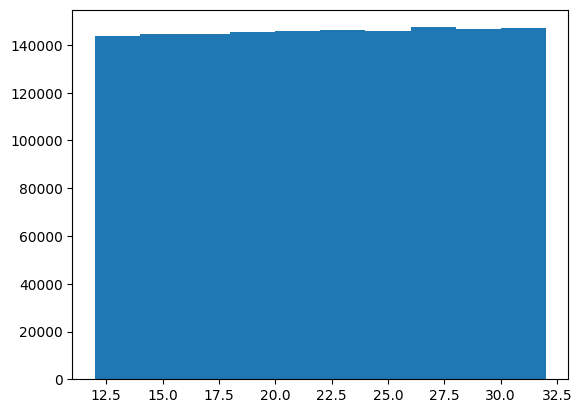

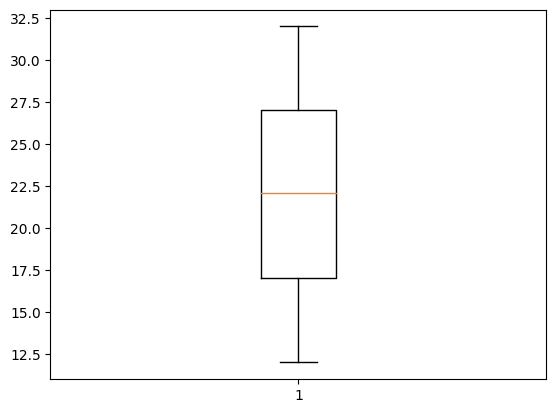

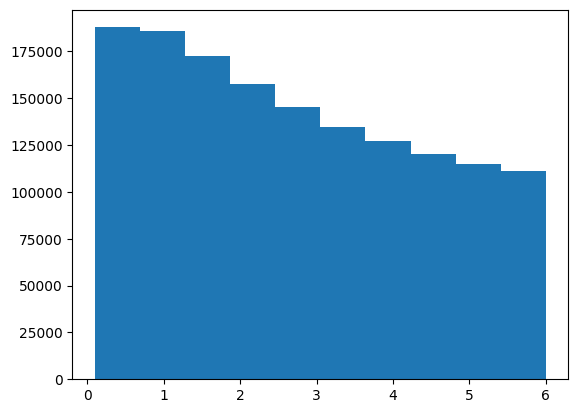

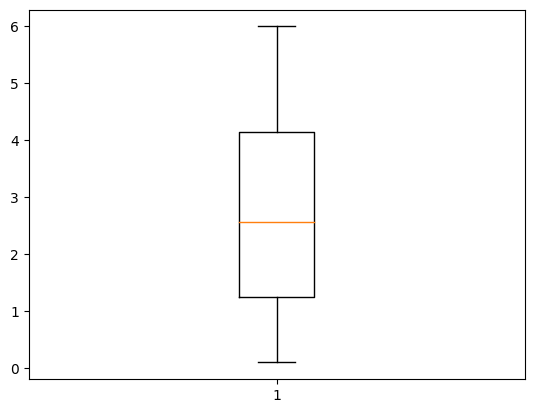

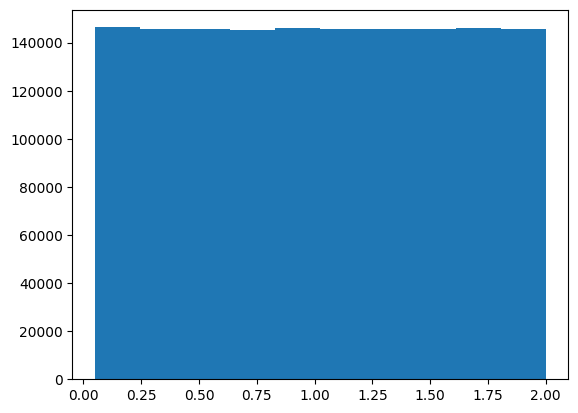

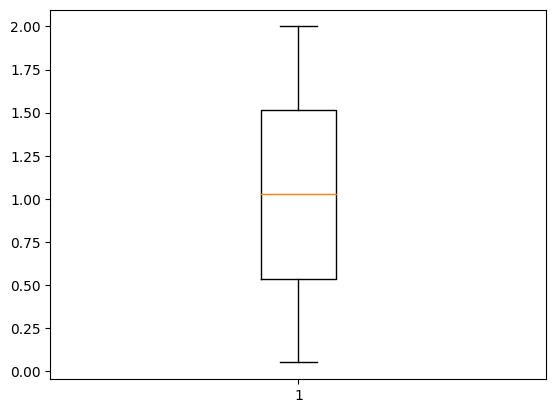

In [10]:
print(filtered_inputs.describe())
for column in inputs.columns:
    # Creating plot
    plt.hist(filtered_inputs[column])
    plt.show()
    plt.boxplot(filtered_inputs[column])
    plt.show()

In [11]:
filtered_results["availability"].describe()

count    1.457619e+06
mean     9.929238e+01
std      1.374950e+00
min      9.500000e+01
25%      9.964200e+01
50%      9.999200e+01
75%      9.999900e+01
max      9.999900e+01
Name: availability, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x311174610>,
 'caps': [<matplotlib.lines.Line2D at 0x311174460>,
 'boxes': [<matplotlib.lines.Line2D at 0x311174c70>],
 'medians': [<matplotlib.lines.Line2D at 0x311122590>],
 'fliers': [<matplotlib.lines.Line2D at 0x3111215a0>],
 'means': []}

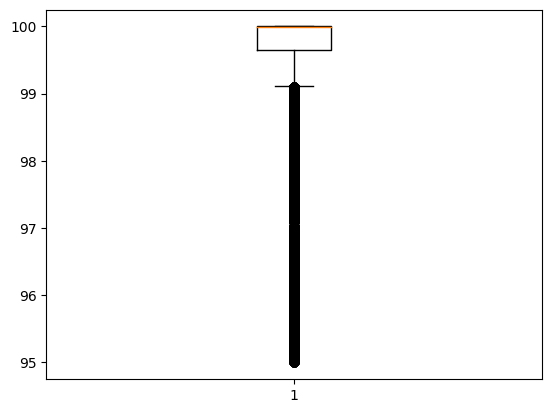

In [12]:
plt.boxplot(filtered_results["availability"])

(array([1.17000e+02, 1.43000e+02, 1.97000e+02, 2.01000e+02, 4.56000e+02,
        2.87000e+02, 3.21000e+02, 3.34000e+02, 6.35000e+02, 3.57000e+02,
        3.67000e+02, 3.93000e+02, 7.40000e+02, 3.59000e+02, 4.04000e+02,
        4.30000e+02, 7.46000e+02, 3.59000e+02, 4.23000e+02, 3.98000e+02,
        7.65000e+02, 3.63000e+02, 4.11000e+02, 3.57000e+02, 7.39000e+02,
        4.06000e+02, 3.83000e+02, 4.02000e+02, 6.89000e+02, 4.39000e+02,
        4.02000e+02, 3.95000e+02, 7.55000e+02, 4.18000e+02, 3.94000e+02,
        4.01000e+02, 7.20000e+02, 4.17000e+02, 3.95000e+02, 4.33000e+02,
        7.08000e+02, 3.88000e+02, 3.76000e+02, 4.02000e+02, 7.64000e+02,
        3.99000e+02, 4.09000e+02, 3.98000e+02, 7.66000e+02, 3.49000e+02,
        4.01000e+02, 3.84000e+02, 7.36000e+02, 3.44000e+02, 2.29000e+03,
        1.49900e+03, 2.83600e+03, 1.46600e+03, 1.43900e+03, 1.47200e+03,
        2.79600e+03, 1.45200e+03, 1.52800e+03, 1.47600e+03, 2.79600e+03,
        1.46300e+03, 1.50700e+03, 1.54100e+03, 2.91

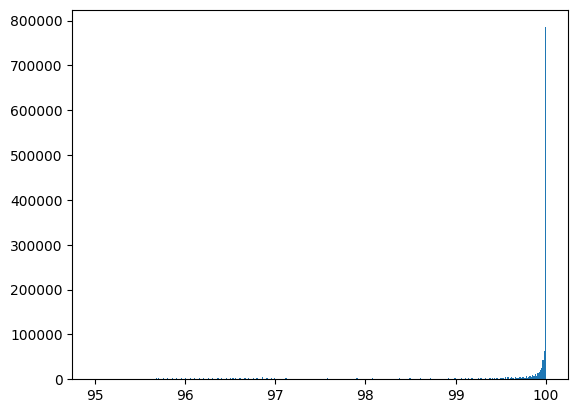

In [13]:
plt.hist(filtered_results["availability"], bins=400)

In [14]:
test_output1 = np.log(filtered_results["availability"])
print(test_output1.describe())
test_output2 = np.log10(filtered_results["availability"])
print(test_output2.describe())

count    1.457619e+06
mean     4.597971e+00
std      1.402173e-02
min      4.553877e+00
25%      4.601584e+00
50%      4.605090e+00
75%      4.605160e+00
max      4.605160e+00
Name: availability, dtype: float64
count    1.457619e+06
mean     1.996874e+00
std      6.089561e-03
min      1.977724e+00
25%      1.998442e+00
50%      1.999965e+00
75%      1.999996e+00
max      1.999996e+00
Name: availability, dtype: float64


(array([  16918.,   52194.,   76535.,   76669.,   11030.,   10137.,
          13372.,   21422.,   53848., 1125494.]),
 array([4.55387689, 4.55900522, 4.56413355, 4.56926188, 4.57439021,
        4.57951854, 4.58464687, 4.5897752 , 4.59490353, 4.60003186,
        4.60516019]),
 <BarContainer object of 10 artists>)

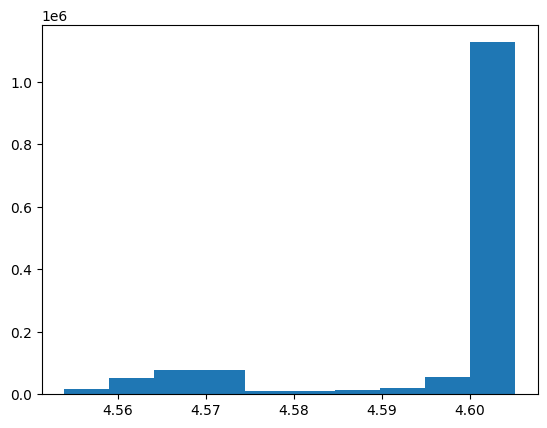

In [15]:
plt.hist(test_output1)

(array([  16918.,   52194.,   76535.,   76669.,   11030.,   10137.,
          13372.,   21422.,   53848., 1125494.]),
 array([1.97772361, 1.97995081, 1.98217802, 1.98440522, 1.98663243,
        1.98885963, 1.99108684, 1.99331404, 1.99554125, 1.99776845,
        1.99999566]),
 <BarContainer object of 10 artists>)

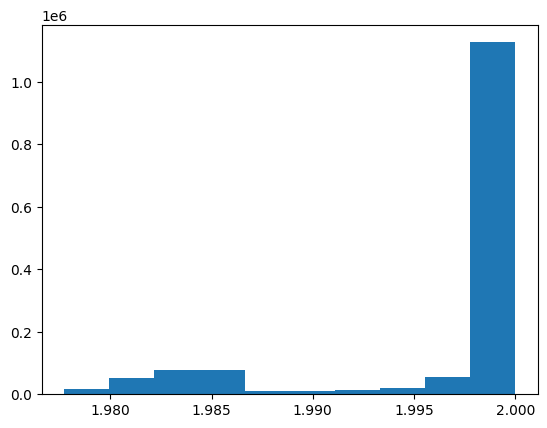

In [16]:
plt.hist(test_output2)

In [17]:
# filtered_results["availability"] = np.log10(filtered_results["availability"])

In [18]:
df = filtered_inputs.assign(availability=filtered_results["availability"])
df.head()

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint,availability
0,-16.284610,-53.833962,-16.791579,15.777944,55.604089,16.155547,12.731030,1.053027,0.721533,60.752933,25.492447,5.587639,0.517839,99.904
1,-19.589594,-47.124346,-25.670642,8.138563,68.860880,22.226415,13.567632,4.362265,0.351699,58.632002,13.328408,5.246875,1.412518,99.999
3,-7.438339,-65.779685,-40.611067,13.980570,79.680713,14.203504,5.407456,1.065575,0.366528,62.943757,30.125849,4.965485,1.081404,99.999
4,-31.421909,-51.281737,-86.449047,15.837202,66.010417,9.488156,12.731030,2.561817,0.116897,56.777167,21.047025,4.254455,0.368052,99.990
5,-17.303467,-41.668725,-66.343144,12.480028,27.720772,31.814645,8.326742,4.452849,0.583401,64.208048,17.289375,2.862834,1.010339,99.554


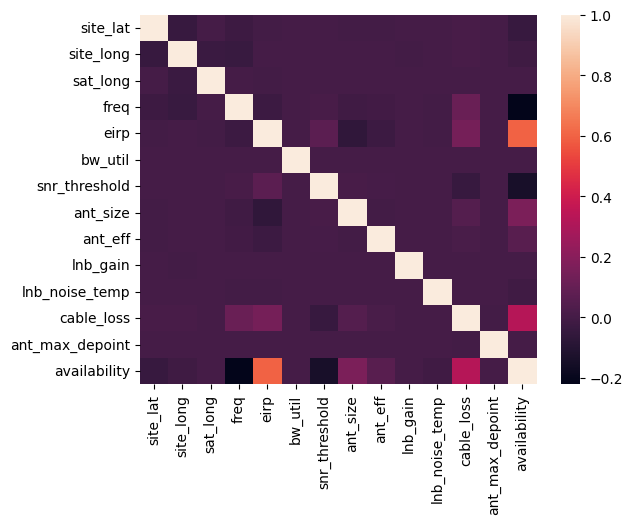

In [19]:
sns.heatmap(df.corr())
plt.show()

In [20]:
df_majority_data = df[df['availability'] >= 99.5]
df_minority_data = df[df['availability'] < 99.5]

In [21]:
df_minority_data.count()

site_lat           333973
site_long          333973
sat_long           333973
freq               333973
eirp               333973
bw_util            333973
snr_threshold      333973
ant_size           333973
ant_eff            333973
lnb_gain           333973
lnb_noise_temp     333973
cable_loss         333973
ant_max_depoint    333973
availability       333973
dtype: int64

In [22]:
df_data_undersample = df_majority_data.sample(int(df_minority_data['availability'].count()/2))

In [23]:
df_balanced = pd.concat([df_data_undersample, df_minority_data], axis=0)
print(df_balanced.head())
df_balanced.describe()

          site_lat  site_long   sat_long       freq       eirp    bw_util  \
898201  -10.815625 -70.212029 -89.014658  12.060591  63.934330   9.866704   
512356  -20.434257 -64.254467 -45.855539   9.673918  60.443891   4.247759   
1058856 -25.198217 -54.660742 -55.733845   9.218446  42.463455  24.197615   
789537  -18.919968 -35.937404 -28.512886   6.145855  56.422258  15.431326   
405980  -20.052285 -55.620006 -34.995308  17.089069  67.250151  15.972316   

         snr_threshold  ant_size   ant_eff   lnb_gain  lnb_noise_temp  \
898201       11.382789  0.725467  0.270658  60.155611       29.177010   
512356       14.211092  2.754566  0.856391  64.409483       26.113469   
1058856      16.554948  2.167705  0.442929  64.237215       15.193222   
789537       15.063918  1.301860  0.256946  62.413023       18.490351   
405980       15.063918  1.552095  0.575607  55.985002       16.261304   

         cable_loss  ant_max_depoint  availability  
898201     4.365155         0.421540        9

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint,availability
count,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000,500959.000000
mean,-14.413327,-53.073849,-52.337720,12.374232,40.023613,18.501000,9.601798,2.190319,0.541925,59.994594,22.097445,2.230960,1.025103,98.018384
std,10.655309,10.699413,33.548912,3.945932,17.191067,10.099525,5.797479,1.280520,0.260497,2.889925,5.772543,1.585788,0.563048,1.735496
min,-33.689911,-72.889971,-107.999782,3.000081,15.000334,1.000017,-2.297824,0.100003,0.100003,55.000006,12.000277,0.100010,0.050009,95.000000
25%,-23.679510,-62.018911,-82.587543,9.417629,26.067717,9.749760,5.134135,1.062671,0.314913,57.493698,17.112793,0.891463,0.537552,96.350000
50%,-13.605850,-52.878010,-52.265368,13.040361,36.694453,18.508016,9.605005,2.138697,0.538348,59.993385,22.148474,1.876142,1.025028,98.276000
75%,-5.043383,-43.852838,-22.059526,15.766818,51.490160,27.235370,14.211092,3.291490,0.766614,62.493296,27.106534,3.343267,1.512987,99.976000
max,2.819986,-34.800036,2.999885,17.999990,79.999898,35.999977,19.590329,4.499995,0.999997,64.999992,31.999910,5.999989,1.999997,99.999000


In [24]:
x = df_balanced.drop('availability',axis='columns')
y = np.log(df_balanced['availability'])

count    500959.000000
mean          4.584998
std           0.017721
min           4.553877
25%           4.567987
50%           4.587780
75%           4.604930
max           4.605160
Name: availability, dtype: float64


(array([ 16918.,  52194.,  76535.,  76669.,  11030.,  10137.,  13372.,
         21422.,  53848., 168834.]),
 array([4.55387689, 4.55900522, 4.56413355, 4.56926188, 4.57439021,
        4.57951854, 4.58464687, 4.5897752 , 4.59490353, 4.60003186,
        4.60516019]),
 <BarContainer object of 10 artists>)

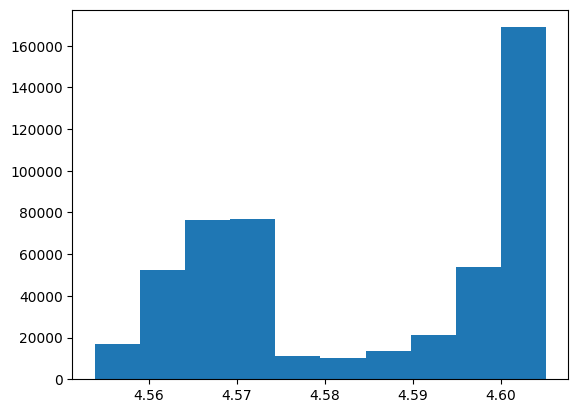

In [25]:
print(y.describe())
plt.hist(y)

In [26]:
# setando a semente para divisão dos conjuntos de treino e teste
np.random.seed(0)

In [27]:
# separando os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [28]:
# alguns dados estatisticos por atributo
x_train.describe()

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint
count,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000,400767.000000
mean,-14.427868,-53.081619,-52.335424,12.377444,40.005647,18.495531,9.598168,2.190021,0.541972,59.994462,22.089845,2.233202,1.024768
std,10.658973,10.701915,33.540141,3.945547,17.185330,10.097866,5.795686,1.280532,0.260509,2.890303,5.771603,1.586315,0.563140
min,-33.689838,-72.889971,-107.999782,3.000081,15.000334,1.000056,-2.297824,0.100003,0.100003,55.000006,12.000423,0.100010,0.050009
25%,-23.700221,-62.026863,-82.567769,9.422347,26.054203,9.751220,5.134135,1.062732,0.314821,57.492367,17.103927,0.893389,0.536980
50%,-13.623075,-52.886872,-52.261265,13.043739,36.687582,18.497877,9.605005,2.138970,0.538876,59.996165,22.137684,1.878946,1.025073
75%,-5.058171,-43.859526,-22.098802,15.769557,51.444004,27.228867,14.211092,3.289535,0.766687,62.492889,27.097970,3.346462,1.513139
max,2.819986,-34.800075,2.999885,17.999983,79.999898,35.999977,19.590329,4.499988,0.999997,64.999992,31.999910,5.999989,1.999992


In [29]:
# normalização dos dados
preprocessParams = preprocessing.StandardScaler().fit(x_train)
x_train_normalized = preprocessParams.transform(x_train)
x_test_normalized = preprocessParams.transform(x_test)

In [30]:
y_train = np.log10(y_train)
y_test = np.log10(y_test)

In [31]:
feature_names = filtered_inputs.columns

In [32]:
# teste de outros modelos de IA
model1 = LinearRegression()
model1.fit(x_train_normalized, y_train)

LinearRegression()

In [33]:
model1.score(x_test_normalized, y_test)

0.6497925796650413

In [34]:
# Get the metrics on the validation data
predicted_availability1 = model1.predict(x_test_normalized)
mae1 = mean_absolute_error(y_test, predicted_availability1)
print('Linear test MAE = ', mae1)

Linear test MAE =  tf.Tensor(0.00082874989234162, shape=(), dtype=float64)


In [35]:
mse1 = mean_squared_error(y_test, predicted_availability1)
rmse1 = mse1**.5
print('Linear test MSE = ', mse1)
print('Linear test RMSE = ', rmse1)

Linear test MSE =  tf.Tensor(9.89174682973984e-07, shape=(), dtype=float64)
Linear test RMSE =  tf.Tensor(0.0009945726132233805, shape=(), dtype=float64)


In [36]:
model2 = RandomForestRegressor()
model2.fit(x_train_normalized, y_train)

RandomForestRegressor()

In [37]:
# save model
joblib.dump(model2, "random_forest_logout_dsbal.joblib")

['random_forest_logout_dsbal.joblib']

In [38]:
model2.score(x_test_normalized, y_test)

0.8719897240572202

In [39]:
# Get the metrics on the validation data
predicted_availability2 = model2.predict(x_test_normalized)

In [40]:
mae2 = mean_absolute_error(y_test, predicted_availability2)
print('Random forest test MAE = ', mae2)

Random forest test MAE =  tf.Tensor(0.0003880861610175786, shape=(), dtype=float64)


In [41]:
mse2 = mean_squared_error(y_test, predicted_availability2)
rmse2 = mse2**.5
print('Random forest test MSE = ', mse2)
print('Random forest test RMSE = ', rmse2)

Random forest test MSE =  tf.Tensor(3.615700775329101e-07, shape=(), dtype=float64)
Random forest test RMSE =  tf.Tensor(0.0006013069744588949, shape=(), dtype=float64)


In [42]:
params = model2.get_params()
params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

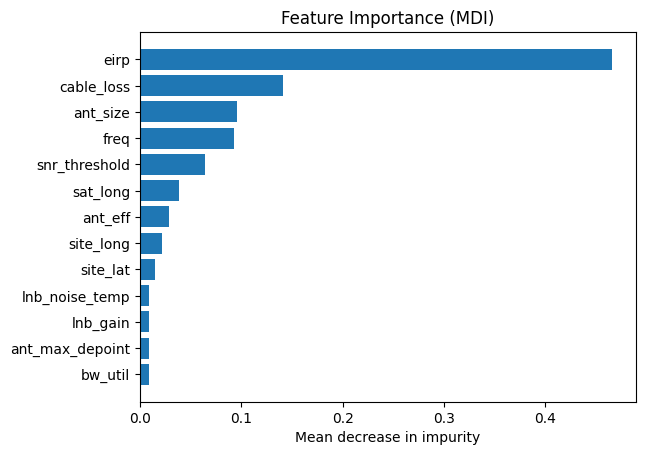

In [43]:
# obtain feature importance
feature_importance2 = model2.feature_importances_

# sort features according to importance
sorted_idx = np.argsort(feature_importance2)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, feature_importance2[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

In [44]:
result2 = permutation_importance(
    model2, x_test_normalized, y_test, n_repeats=10, random_state=42, n_jobs=2
)

tree_importances2 = pd.Series(result2.importances_mean, index=feature_names)

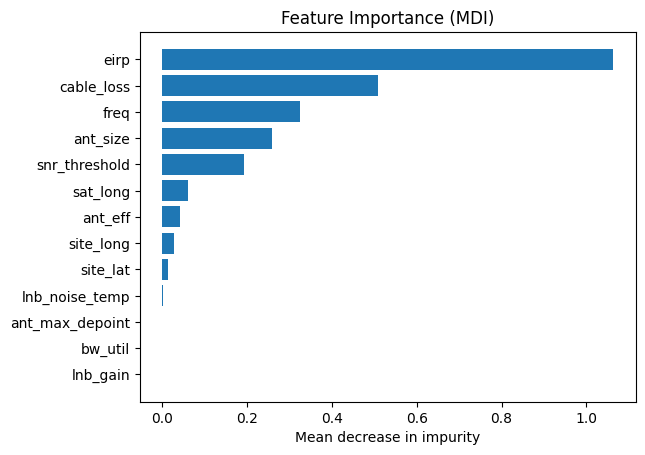

In [45]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances2)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances2[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

Text(0.5, 1.0, 'Permutation Importance (test set)')

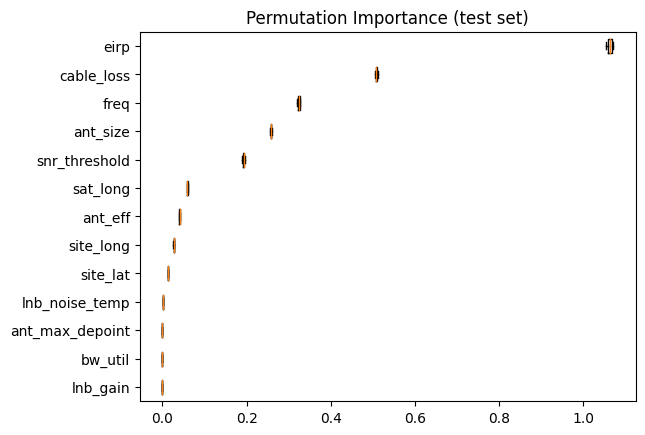

In [46]:
plt.boxplot(
    result2.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")

In [47]:
model3 = HistGradientBoostingRegressor()
model3.fit(x_train_normalized, y_train)

HistGradientBoostingRegressor()

In [48]:
# save model
joblib.dump(model3, "hist_grad_boost_logout_dsbal.joblib")

['hist_grad_boost_logout_dsbal.joblib']

In [49]:
model3.score(x_test_normalized, y_test)

0.7756698293488032

In [50]:
# Get the metrics on the validation data
predicted_availability3 = model3.predict(x_test_normalized)

In [51]:
mae3 = mean_absolute_error(y_test, predicted_availability3)
print('Hist. Grad. Boost. test MAE = ', mae3)

Hist. Grad. Boost. test MAE =  tf.Tensor(0.0005910665377854465, shape=(), dtype=float64)


In [52]:
mse3 = mean_squared_error(y_test, predicted_availability3)
rmse3 = mse3**.5
print('Hist. Grad. Boost. test MSE = ', mse3)
print('Hist. Grad. Boost. test RMSE = ', rmse3)

Hist. Grad. Boost. test MSE =  tf.Tensor(6.336294223096633e-07, shape=(), dtype=float64)
Hist. Grad. Boost. test RMSE =  tf.Tensor(0.0007960084310543849, shape=(), dtype=float64)


In [53]:
params = model3.get_params()
params

{'categorical_features': None,
 'early_stopping': 'auto',
 'interaction_cst': None,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'quantile': None,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

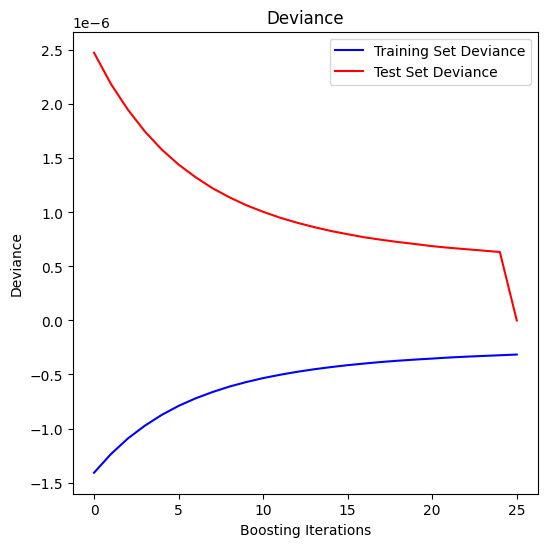

In [54]:
test_score = np.zeros((len(model3.train_score_),), dtype=np.float64)

for i, y_pred in enumerate(model3.staged_predict(x_test_normalized)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(len(model3.train_score_)),
    model3.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(len(model3.train_score_)), test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
plt.show()

In [55]:
result3 = permutation_importance(
    model3, x_test_normalized, y_test, n_repeats=10, random_state=42, n_jobs=2
)

tree_importances3 = pd.Series(result3.importances_mean, index=feature_names)

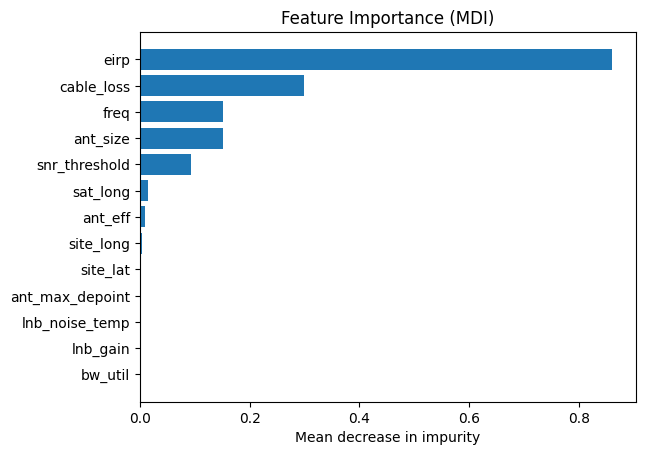

In [56]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances3)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances3[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

Text(0.5, 1.0, 'Permutation Importance (test set)')

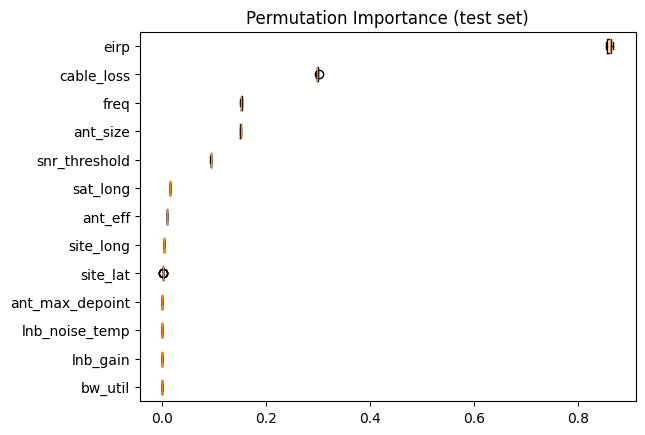

In [57]:
plt.boxplot(
    result3.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")

In [58]:
eval_set = [(x_train_normalized, y_train), (x_test_normalized, y_test)]
model4 = xgb.XGBRegressor()
model4.fit(x_train_normalized, 
           y_train, 
           verbose=True,
           eval_set=eval_set)

[0]	validation_0-rmse:0.00136	validation_1-rmse:0.00136
[1]	validation_0-rmse:0.00116	validation_1-rmse:0.00116
[2]	validation_0-rmse:0.00102	validation_1-rmse:0.00102
[3]	validation_0-rmse:0.00093	validation_1-rmse:0.00093
[4]	validation_0-rmse:0.00087	validation_1-rmse:0.00088
[5]	validation_0-rmse:0.00083	validation_1-rmse:0.00084
[6]	validation_0-rmse:0.00081	validation_1-rmse:0.00081
[7]	validation_0-rmse:0.00078	validation_1-rmse:0.00079
[8]	validation_0-rmse:0.00077	validation_1-rmse:0.00077
[9]	validation_0-rmse:0.00075	validation_1-rmse:0.00076
[10]	validation_0-rmse:0.00074	validation_1-rmse:0.00075
[11]	validation_0-rmse:0.00074	validation_1-rmse:0.00074
[12]	validation_0-rmse:0.00073	validation_1-rmse:0.00074
[13]	validation_0-rmse:0.00072	validation_1-rmse:0.00073
[14]	validation_0-rmse:0.00071	validation_1-rmse:0.00072
[15]	validation_0-rmse:0.00071	validation_1-rmse:0.00072
[16]	validation_0-rmse:0.00071	validation_1-rmse:0.00071
[17]	validation_0-rmse:0.00070	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [59]:
# save model
joblib.dump(model4, "xgboost_logout_dsbal.joblib")

['xgboost_logout_dsbal.joblib']

In [60]:
results4 = model4.evals_result()
results4

{'validation_0': OrderedDict([('rmse',
               [0.00136211269334183,
                0.00115514270465738,
                0.0010177131913779,
                0.00093041048844574,
                0.0008734870195633,
                0.00083454198040306,
                0.00080601546246943,
                0.00078337732157869,
                0.00076808653182307,
                0.00075487206792414,
                0.00074496453314589,
                0.0007362349480878,
                0.00072978611558523,
                0.00072220714311231,
                0.00071451760513936,
                0.00070909007497397,
                0.00070581847257566,
                0.00070067254938582,
                0.00069779119358806,
                0.00069542809478179,
                0.0006932059774903,
                0.00069046476323416,
                0.0006881091154998,
                0.00068610816845375,
                0.00068426345773875,
                0.0006822265147471,
     

In [61]:
model4.score(x_test_normalized, y_test)

0.8577546150201014

In [62]:
# Get the metrics on the validation data
predicted_availability4 = model4.predict(x_test_normalized)

In [63]:
mae4 = mean_absolute_error(y_test, predicted_availability4)
print('XGBoost test MAE = ', mae4)

XGBoost test MAE =  tf.Tensor(0.00046015618, shape=(), dtype=float32)


In [64]:
mse4 = mean_squared_error(y_test, predicted_availability4)
rmse4 = mse4**.5
print('XGBoost test MSE = ', mse4)
print('XGBoost test RMSE = ', rmse4)

XGBoost test MSE =  tf.Tensor(4.0177807e-07, shape=(), dtype=float32)
XGBoost test RMSE =  tf.Tensor(0.00063385966, shape=(), dtype=float32)


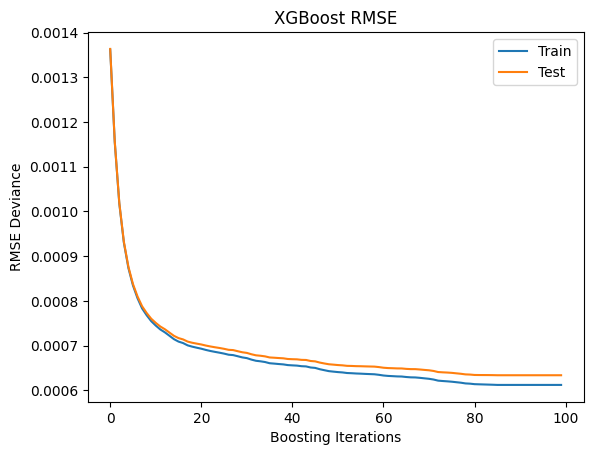

In [65]:
epochs = len(results4['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, results4['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results4['validation_1']['rmse'], label='Test')

plt.title('XGBoost RMSE')
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE Deviance")
plt.legend(loc="upper right");

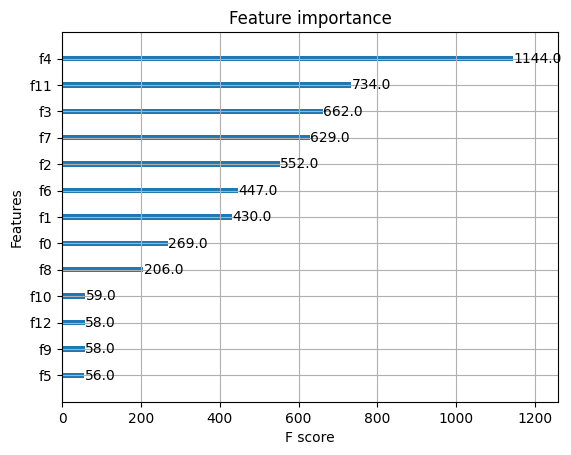

In [66]:
xgb.plot_importance(model4);

In [67]:
result4 = permutation_importance(
    model4, x_test_normalized, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [68]:
tree_importances4 = pd.Series(result4.importances_mean, index=feature_names)

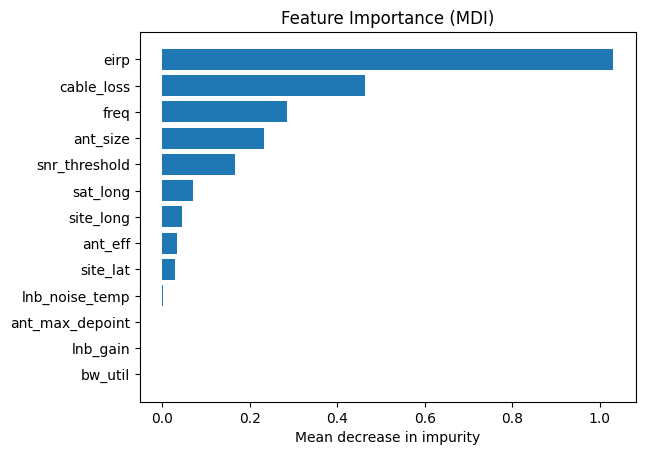

In [69]:
# sort features according to importance
sorted_idx = np.argsort(tree_importances4)
pos = np.arange(sorted_idx.shape[0])

# plot feature importances
plt.barh(pos, tree_importances4[sorted_idx], align="center")

plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.xlabel("Mean decrease in impurity");

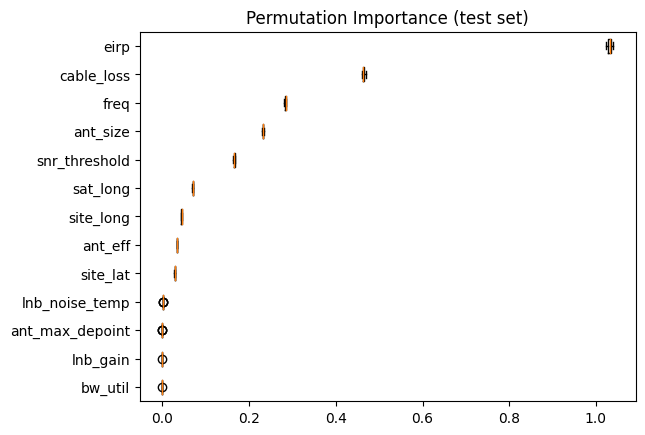

In [70]:
plt.boxplot(
    result4.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)

plt.title("Permutation Importance (test set)")
plt.show()

In [71]:
model6 = VotingRegressor([("linear", model1), ("random-forest", model2), ("hist-grad-boost-reg", model3), ("xgb", model4)]) #("svr_rbf", model5), ("svr_poly", model7)])
model6.fit(x_train_normalized, y_train)

VotingRegressor(estimators=[('linear', LinearRegression()),
                            ('random-forest', RandomForestRegressor()),
                            ('hist-grad-boost-reg',
                             HistGradientBoostingRegressor()),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False...
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...))])

In [72]:
# save model
joblib.dump(model6, "voting_logout_dsbal.joblib")

['voting_logout_dsbal.joblib']

In [73]:
model6.score(x_test_normalized, y_test)

0.8324711335197548

In [74]:
predicted_availability6 = model6.predict(x_test_normalized)

In [75]:
mae6 = mean_absolute_error(y_test, predicted_availability6)
print('Voting test MAE = ', mae6)

Voting test MAE =  tf.Tensor(0.0005164475252265277, shape=(), dtype=float64)


In [76]:
mse6 = mean_squared_error(y_test, predicted_availability6)
rmse6 = mse6**.5
print('Voting test MSE = ', mse6)
print('Voting test RMSE = ', rmse6)

Voting test MSE =  tf.Tensor(4.731918964797712e-07, shape=(), dtype=float64)
Voting test RMSE =  tf.Tensor(0.0006878894507693596, shape=(), dtype=float64)


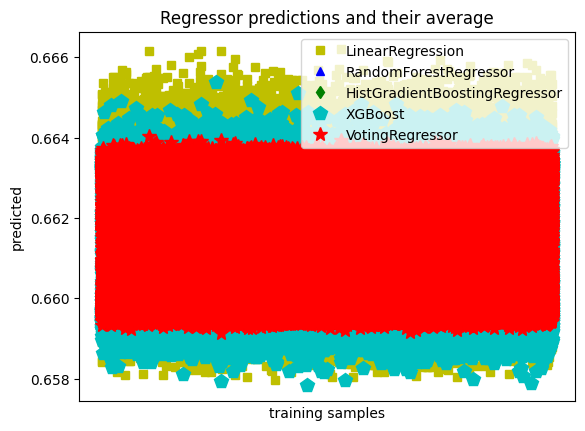

In [77]:
plt.figure()
plt.plot(predicted_availability1, "ys", label="LinearRegression")
plt.plot(predicted_availability2, "b^", label="RandomForestRegressor")
plt.plot(predicted_availability3, "gd", label="HistGradientBoostingRegressor")
plt.plot(predicted_availability4, "pc", ms=10, label="XGBoost")
plt.plot(predicted_availability6, "r*", ms=10, label="VotingRegressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()